In [1]:
import numpy as np
import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from torchvision import models

from typing import List, Tuple, Dict

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
%cd data
! ls

/notebooks/data
test  train


In [4]:
data_path = Path.cwd()
train_path, test_path = Path(data_path, 'train'), Path(data_path, 'test')

In [ ]:
%cd ..

In [5]:
class AirfoilDataset(Dataset):
    __AVAILABLE_MODES = ['train', 'val', 'test']
    
    def __init__(self, files: List[str], mode: str) -> None:
        super(AirfoilDataset, self).__init__()
        self.files = sorted(files)
        self.mode = mode
        
        if self.mode not in self.__AVAILABLE_MODES:
            print(f"Available data modes: {self.__AVAILABLE_MODES}")
            raise NameError
        
        self.len_ = len(files)
        
    def __len__(self) -> int:
        return self.len_
    
    def load_sample(self, filename: str) -> Tuple[Tensor, Tensor]:
        with np.load(filename) as data:
            a = data['a']
            x = torch.from_numpy(a[:3, ...])
            y = torch.from_numpy(a[3:, ...])
            return x, y
        
    def __getitem__(self, index: int) -> Tuple[Tensor, Tensor]:
        filename = self.files[index]
        x, y = self.load_sample(filename)
        x = self.__prepare_sample(x)
        x = x.float()
        y = y.float()
        return x, y
    
    def __prepare_sample(self, x: Tensor) -> Tensor:
        x = self.__std_mean(x)
        return x
        
    def __std_mean(self, t: Tensor) -> Tensor:
        std, mean = torch.std_mean(t, dim=0)
        t = (t - mean) / std
        return t

In [6]:
def train(model: nn.Module, opt: optim.Adam, train_dataset: AirfoilDataset, \
          val_dataset: AirfoilDataset, loss_func: nn.MSELoss, \
          scheduler: optim.lr_scheduler.StepLR, batch_size: int = 64, epochs: int = 10) -> List[List[float]]:
    losses = []
    train_total = len(train_dataset)
    val_total = len(val_dataset)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    for epoch in range(epochs):
        train_loss = fit_epoch(model, opt, train_loader, loss_func, batch_size, train_total=train_total)
        val_loss = val_epoch(model, val_loader, loss_func, batch_size, val_total=val_total)
        
        losses.append([train_loss, val_loss])
        print(f"Epoch: {epoch}, train loss: {train_loss}, val loss: {val_loss}")
        scheduler.step()
    return losses


def fit_epoch(model: nn.Module, opt: optim.Adam, train_loader: DataLoader,\
              loss_func: nn.MSELoss, batch_size: int, train_total: int) -> float:
    total_loss = 0
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        outp = model(x)
        loss = loss_func(outp, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.sum().item()
        
    return total_loss / train_total


def val_epoch(model: nn.Module, val_loader: DataLoader, loss_func: nn.MSELoss, \
              batch_size: int, val_total: int) -> float:
    total_loss = 0
    model.eval()
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(False):
            outp = model(x)
            loss = loss_func(outp, y)
        total_loss += loss.item()
        
    return total_loss / val_total

In [8]:
class UNet(nn.Module):
    def __init__(self, channelExponent: int = 6) -> None:
        super().__init__()
        channels = int(2 ** channelExponent + 0.5)
        self.layer1 = nn.Sequential()
        self.layer1.add_module('layer1_conv', nn.Conv2d(3, channels, 4, 2, 1, bias=True))

        self.layer1 = nn.Sequential()
        self.layer1.add_module('layer1_conv', nn.Conv2d(3, channels, 4, 2, 1, bias=True))

        self.layer2 = self.__get_block_unet(channels  , channels*2, 'layer2', transposed=False )
        self.layer2b= self.__get_block_unet(channels*2, channels*2, 'layer2b',transposed=False )
        self.layer3 = self.__get_block_unet(channels*2, channels*4, 'layer3', transposed=False )
        # note the following layer also had a kernel size of 2 in the original version (cf https://arxiv.org/abs/1810.08217)
        # it is now changed to size 4 for encoder/decoder symmetry; to reproduce the old/original results, please change it to 2
        self.layer4 = self.__get_block_unet(channels*4, channels*8, 'layer4', transposed=False ,  size=4 ) # note, size 4!
        self.layer5 = self.__get_block_unet(channels*8, channels*8, 'layer5', transposed=False , size=2, pad=0)
        self.layer6 = self.__get_block_unet(channels*8, channels*8, 'layer6', transposed=False, size=2, pad=0)

        # note, kernel size is internally reduced by one now
        self.dlayer6 = self.__get_block_unet(channels*8, channels*8, 'dlayer6', transposed=True, size=2, pad=0)
        self.dlayer5 = self.__get_block_unet(channels*16,channels*8, 'dlayer5', transposed=True, size=2, pad=0)
        self.dlayer4 = self.__get_block_unet(channels*16,channels*4, 'dlayer4', transposed=True ) 
        self.dlayer3 = self.__get_block_unet(channels*8, channels*2, 'dlayer3', transposed=True )
        self.dlayer2b= self.__get_block_unet(channels*4, channels*2, 'dlayer2b',transposed=True )
        self.dlayer2 = self.__get_block_unet(channels*4, channels  , 'dlayer2', transposed=True )

        self.dlayer1 = nn.Sequential()
        self.dlayer1.add_module('dlayer1_relu', nn.ReLU(inplace=True))
        self.dlayer1.add_module('dlayer1_tconv', nn.ConvTranspose2d(channels*2, 3, 4, 2, 1, bias=True))

    def forward(self, x: Tensor) -> Tensor:
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out2b= self.layer2b(out2)
        out3 = self.layer3(out2b)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        dout6 = self.dlayer6(out6)
        dout6_out5 = torch.cat([dout6, out5], 1)
        dout5 = self.dlayer5(dout6_out5)
        dout5_out4 = torch.cat([dout5, out4], 1)
        dout4 = self.dlayer4(dout5_out4)
        dout4_out3 = torch.cat([dout4, out3], 1)
        dout3 = self.dlayer3(dout4_out3)
        dout3_out2b = torch.cat([dout3, out2b], 1)
        dout2b = self.dlayer2b(dout3_out2b)
        dout2b_out2 = torch.cat([dout2b, out2], 1)
        dout2 = self.dlayer2(dout2b_out2)
        dout2_out1 = torch.cat([dout2, out1], 1)
        dout1 = self.dlayer1(dout2_out1)
        return dout1

    def __get_block_unet(self, in_c: int, out_c: int, name: str, transposed: bool = False, \
                   size:int = 4, pad: int = 1) -> nn.Sequential:
        block = nn.Sequential()
        block.add_module('%s_relu' % name, nn.ReLU(inplace=True))
        if not transposed:
            block.add_module('%s_conv' % name, nn.Conv2d(in_c, out_c, \
                                                   kernel_size=size,\
                                                   stride=2,\
                                                   padding=pad,\
                                                   bias=True))
        else:
            block.add_module('%s_upsam' % name, nn.Upsample(scale_factor=2,\
                                                      mode='bilinear'))
            block.add_module('%s_convtr' % name, nn.Conv2d(in_c, out_c, \
                                                     kernel_size=(size -1),\
                                                     stride=1,\
                                                     padding=pad,\
                                                     bias=True))
        block.add_module('%s_bn' %name, nn.BatchNorm2d(out_c))
        return block

In [9]:
files = list(train_path.glob('*.npz'))
train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)
train_dset = AirfoilDataset(train_files, 'train')
val_dset = AirfoilDataset(val_files, 'val')

In [17]:
model = UNet()
model.to(device)
params = list(model.parameters())
loss_func = nn.MSELoss()
optimizer = optim.Adam(params, lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [18]:
history = train(model, optimizer, train_dset, val_dset, loss_func, scheduler, epochs=4)

Epoch: 0, train loss: 14171.800109863281, val loss: 16192.403918457032
Epoch: 1, train loss: 14032.926104736329, val loss: 16100.006286621094
Epoch: 2, train loss: 13869.679248046876, val loss: 15750.00810546875
Epoch: 3, train loss: 13671.695587158203, val loss: 15941.202685546876


In [12]:
def visualize_history(history: List[List[float]]) -> None:
    for i in range(len(history[0])):
        fig, ax = plt.subplots(figsize=(10,6))
        sns.lineplot(x=list(range(0, len(history))), y=[epoch_hist[i] for epoch_hist in history])
        ax.set_ylabel('loss')
        ax.set_xlabel('epochs')
        plt.show()

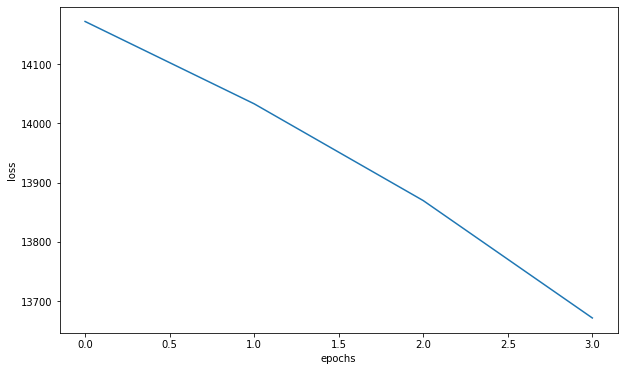

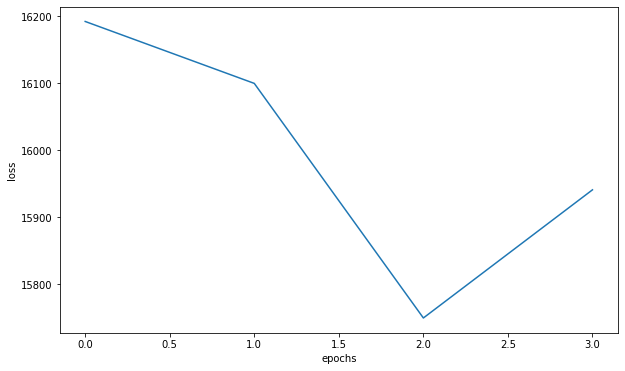

In [19]:
visualize_history(history)

In [16]:
val_loader = DataLoader(val_dset, shuffle=False)
preds = None
g_t = None
model.eval()
    for x, y in val_loader:
    with torch.set_grad_enabled(False):
        x, y = x.to(device), y
        preds = model(x)
        g_t = y.cpu()
    break

In [22]:
%cd ..

/notebooks


In [23]:
Path.cwd()

PosixPath('/notebooks')

In [27]:
torch.save(model.state_dict(), 'model_weights.pth')